In [1]:
import itertools # 是 Python 的內建模組，提供了一組用於處理迭代器的函數和工具。
                 # 它包含了各種用於高效處理迭代器的函數，可以幫助我們編寫更簡潔、高效的代碼。
import sys # 是 Python 的內建模組，提供了與 Python 解釋器和運行環境相關的功能。
# sys.path 是一個列表，包含了 Python 解釋器在導入模組時會搜尋的路徑。
# 當你使用 import 語句導入模組時 Python 會依次在 sys.path 中的路徑下尋找對應的模組文件。
sys.path.append("../ecg-classification/")
# sys.path.append("C:\\Users\\Chen_Lab01\\Documents\\GitHub/ecg-classification")
# from IPython.display import Video
# import cv2
from matplotlib import pyplot as plt
plt.style.use("ggplot") #  是 Matplotlib 庫中用於設置繪圖樣式的函數。它使用了一種名為 "ggplot" 的預定義樣式
import matplotlib
matplotlib.use("TkAgg")
                        #  該樣式模仿了 R 語言的 ggplot2 繪圖包的外觀。
# print(sys.path)
from ecg_tools.config import EcgConfig, Mode
from ecg_tools.data_loader import DatasetConfig, get_data_loaders
from ecg_tools.model import ECGformer
from ecg_tools.train import ECGClassifierTrainer



## Data

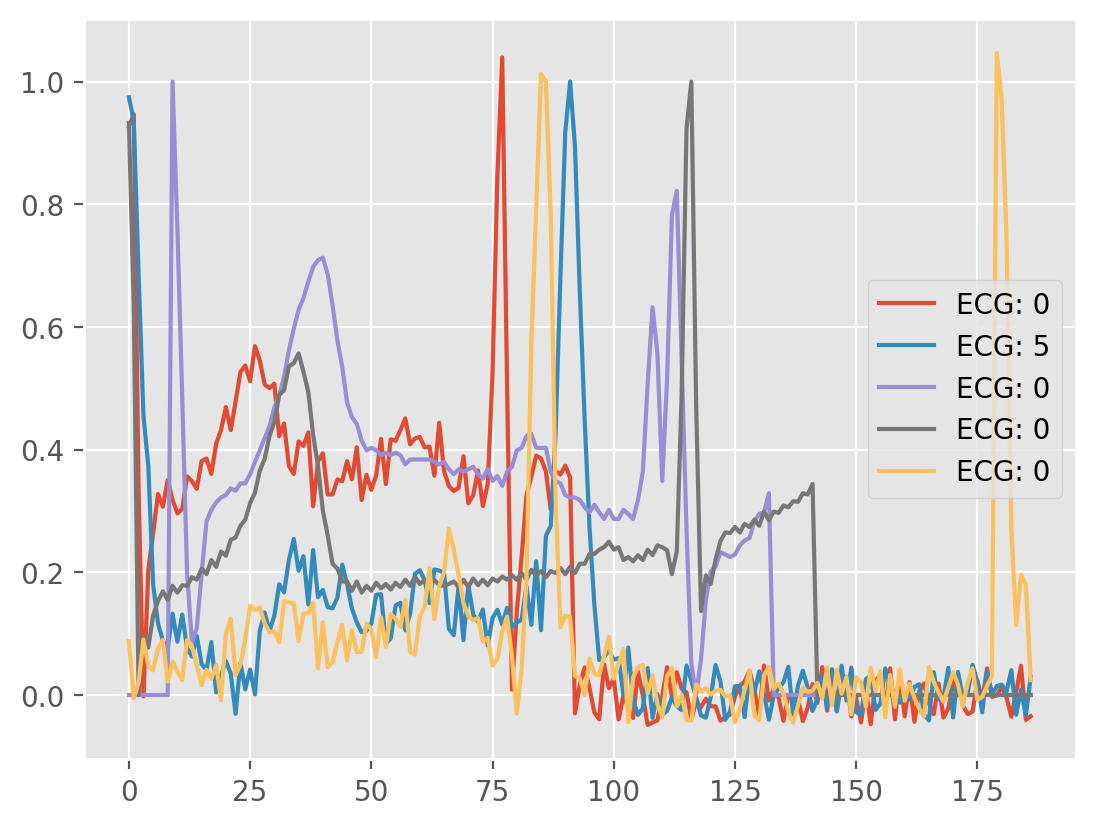

In [2]:
# 隨機抽 5 筆 ECG Data 出來觀察
NUM_EXAMPLES = 5
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)

plt.figure(1, dpi=200) # dpi 設置解析度
labels = []

for idx, data in enumerate(data_loaders[Mode.train]):
    if idx == NUM_EXAMPLES:
        break
    plt.plot(data[0][0, ...].squeeze().numpy())
    labels.append(int(data[1][0, ...].numpy()))

plt.legend([f"ECG: {label}" for label in labels])
%matplotlib inline
plt.show()

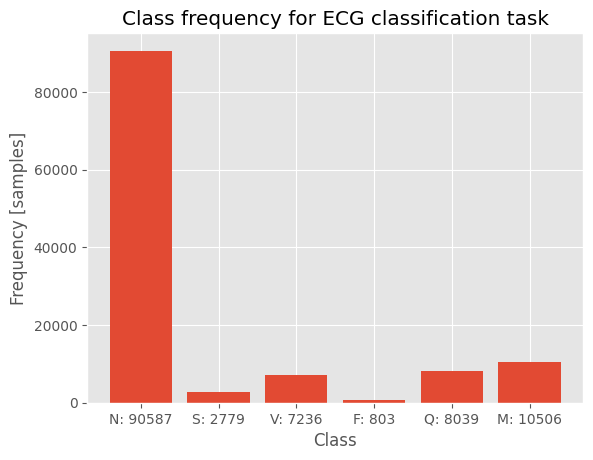

In [3]:
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)
classes = ["N", "S", "V", "F", "Q", "M"]
labels = {
    idx: 0 for idx in range(len(classes))
}

for data in itertools.chain(*list(data_loaders.values())):
    for label in data[1].numpy():
        labels[int(label)] += 1

plt.bar(range(len(classes)), list(labels.values()), tick_label=[f"{k}: {v}" for k, v in zip(classes, list(labels.values()))])
plt.title("Class frequency for ECG classification task")
plt.ylabel("Frequency [samples]")
plt.xlabel("Class")
%matplotlib inline
plt.show()

## Modeling

In [4]:
config = EcgConfig()
model = ECGformer(
    embed_size=config.model.embed_size,
    num_layers=config.model.num_layers,
    num_heads=config.model.num_heads,
    num_classes=config.model.num_classes,
    signal_length=config.model.signal_length,
    expansion=config.model.expansion,
    input_channels=config.model.input_channels
)
model
from torchinfo import summary
# input = (batch_size, signal_length, input_channels)
summary(model, input_size=(64, config.model.signal_length, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=3) # depth = 3 表示只顯示到第三層
# print(model)




Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [64, 187, 1]              [64, 6]                   36,096                    --
├─LinearEmbedding: 1-1                             [64, 187, 1]              [64, 188, 192]            192                       --
│    └─Linear: 2-1                                 [64, 187, 1]              [64, 187, 192]            384                       --
│    └─LayerNorm: 2-2                              [64, 187, 192]            [64, 187, 192]            384                       --
│    └─GELU: 2-3                                   [64, 187, 192]            [64, 187, 192]            --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [64, 188, 192] 

### Quantization Test

In [5]:
import torch.quantization
model(torch.randn(1, config.model.signal_length, 1)).shape

# 使用 Eager Mode Quantization
# 將 torch.nn.Linear 的參數映射到 -127~127 之間
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

quantized_model
from torchinfo import summary
summary(quantized_model, input_size=(64, config.model.signal_length, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=5) # depth = 3 表示只顯示到第三層
# print(model)


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [64, 187, 1]              [64, 6]                   36,096                    --
├─LinearEmbedding: 1-1                             [64, 187, 1]              [64, 188, 192]            192                       --
│    └─Linear: 2-1                                 [64, 187, 1]              [64, 187, 192]            --                        --
│    └─LayerNorm: 2-2                              [64, 187, 192]            [64, 187, 192]            384                       --
│    └─GELU: 2-3                                   [64, 187, 192]            [64, 187, 192]            --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [64, 188, 192] 

### Model ParameterTest

In [6]:
for name in quantized_model.state_dict():
   print(name)

print(quantized_model.state_dict()['encoder.0.0.block.1.queries_projection._packed_params._packed_params'])

positional_encoding
encoder.0.0.block.0.weight
encoder.0.0.block.0.bias
encoder.0.0.block.1.queries_projection.scale
encoder.0.0.block.1.queries_projection.zero_point
encoder.0.0.block.1.queries_projection._packed_params.dtype
encoder.0.0.block.1.queries_projection._packed_params._packed_params
encoder.0.0.block.1.values_projection.scale
encoder.0.0.block.1.values_projection.zero_point
encoder.0.0.block.1.values_projection._packed_params.dtype
encoder.0.0.block.1.values_projection._packed_params._packed_params
encoder.0.0.block.1.keys_projection.scale
encoder.0.0.block.1.keys_projection.zero_point
encoder.0.0.block.1.keys_projection._packed_params.dtype
encoder.0.0.block.1.keys_projection._packed_params._packed_params
encoder.0.0.block.1.final_projection.scale
encoder.0.0.block.1.final_projection.zero_point
encoder.0.0.block.1.final_projection._packed_params.dtype
encoder.0.0.block.1.final_projection._packed_params._packed_params
encoder.0.1.block.0.weight
encoder.0.1.block.0.bias
enco

### Visualize Model

In [7]:
quantized_model.eval()
inputs = torch.randn(1, 187, 1)
traced_script_module = torch.jit.trace(quantized_model, inputs)
traced_script_module.save("traced_resnet_model.pth")

# from torchviz import make_dot
# vis_graph = make_dot(quantized_model(inputs), params=dict(quantized_model.named_parameters()), show_attrs=True, show_saved=True)
# vis_graph.view()  # 会在当前目录下保存一个“Digraph.gv.pdf”文件，并在默认浏览器中打开

# import netron
# modelData = 'traced_resnet_model.pth'
# netron.start(modelData)

## Training

TRAINING: 0, loss: 0.6721636652946472. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [02:08<00:00, 23.35it/s] 


TRAINING Accuracy: 0.7703192830085754
[[69902     0   525    55  1988     0]
 [ 2156     0    20     3    44     0]
 [ 4416     0   415     9   948     0]
 [  625     0     5    10     1     0]
 [ 2725     0   107     1  3598     0]
 [ 7751     0   172     7   474     1]]
epoch_loss: 0.0002241292648531668


VALIDATION: 0, loss: 0.7049388885498047. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:12<00:00, 58.79it/s] 


VALIDATION Accuracy: 0.8218333125114441
[[17672     0   148   191   106     0]
 [  543     0     2     6     5     0]
 [  739     0   551    62    96     0]
 [   57     0     2   103     0     0]
 [  177     0    31     2  1398     0]
 [ 1965     0    82    30    24     0]]


TRAINING: 1, loss: 0.6227418780326843. Target: [4, 0, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:22<00:00, 21.05it/s] 


TRAINING Accuracy: 0.8159177899360657
[[69971   307   883   373   680   256]
 [ 1657   409    92     5    45    15]
 [ 2680   107  2380   110   467    44]
 [  423     4    12   201     1     0]
 [  846    60   331    15  5153    26]
 [ 7406    64   507    45   195   188]]
epoch_loss: 0.00020764984262510315


TRAINING: 2, loss: 0.8460443019866943. Target: [2, 4, 0, 0, 0, 0, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:23<00:00, 20.95it/s] 


TRAINING Accuracy: 0.8342989087104797
[[69203   566   784   360   453  1104]
 [ 1157   854   103     4    35    70]
 [ 1781   170  3286   137   200   214]
 [  337     8    19   275     0     2]
 [  562    87   199    10  5435   138]
 [ 6694   137   365    29   167  1013]]
epoch_loss: 0.0002821088035967637


VALIDATION: 2, loss: 0.6673562526702881. Target: [0, 4, 0, 0, 5, 2, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 56.89it/s] 


VALIDATION Accuracy: 0.8690833449363708
[[17758    63    63    47    50   136]
 [  253   262    29     0     1    11]
 [  385    40   945    48    14    16]
 [   55     0     6   101     0     0]
 [  108     6     9     1  1449    35]
 [ 1690    17    33     6    12   343]]


TRAINING: 3, loss: 0.497302383184433. Target: [0, 0, 5, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.78it/s]  


TRAINING Accuracy: 0.8431456089019775
[[68923   616   763   358   396  1414]
 [ 1057   942   110     3    32    79]
 [ 1482   172  3651   131   156   196]
 [  311     7    26   291     0     6]
 [  507    71   142     9  5542   160]
 [ 6286   124   254    29   146  1566]]
epoch_loss: 0.00016582273530657985


TRAINING: 4, loss: 0.748937726020813. Target: [0, 0, 0, 0, 2, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.71it/s]  


TRAINING Accuracy: 0.8532844185829163
[[68539   587   673   342   417  1912]
 [  936  1046   110     3    18   110]
 [ 1233   138  3969   126   131   191]
 [  278     5    37   310     1    10]
 [  489    43   105     5  5622   167]
 [ 5515   124   195    33   136  2402]]
epoch_loss: 0.00024972915172417903


VALIDATION: 4, loss: 0.45805683732032776. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [5, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 56.65it/s]


VALIDATION Accuracy: 0.8814166784286499
[[17331   135    70    96    35   450]
 [  208   307    26     0     0    15]
 [  220    33  1089    67     9    30]
 [   41     0     3   118     0     0]
 [  103     3     5     1  1440    56]
 [ 1191    16    11     9     5   869]]


TRAINING: 5, loss: 0.2606255114078522. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.58it/s] 


TRAINING Accuracy: 0.8609536290168762
[[68481   534   643   317   344  2151]
 [  885  1112   107     2    18    99]
 [ 1103   129  4103   157   139   157]
 [  276     7    31   323     0     4]
 [  435    34    81     7  5709   165]
 [ 5035   118   197    27   132  2896]]
epoch_loss: 8.690413851545588e-05


TRAINING: 6, loss: 0.26305168867111206. Target: [0, 1, 0, 0, 4, 0, 2, 4], Prediction: [0, 1, 0, 0, 4, 0, 1, 4]: 100%|██████████| 2999/2999 [02:26<00:00, 20.45it/s]


TRAINING Accuracy: 0.867799699306488
[[68356   562   611   332   324  2285]
 [  847  1184    91     3     9    89]
 [  951   124  4275   151   120   167]
 [  258     4    38   333     0     8]
 [  439    26    75     4  5737   150]
 [ 4589   109   180    31   100  3396]]
epoch_loss: 8.77131339350157e-05


VALIDATION: 6, loss: 0.3441770374774933. Target: [0, 0, 0, 2, 5, 0, 4, 0], Prediction: [0, 0, 0, 2, 5, 0, 4, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.84it/s] 


VALIDATION Accuracy: 0.9080416560173035
[[17692    38    47    22    12   306]
 [  222   308     7     0     0    19]
 [  205    18  1134    48    13    30]
 [   69     0     4    89     0     0]
 [  123     3     1     0  1436    45]
 [  951     3     7     2     4  1134]]


TRAINING: 7, loss: 0.24129793047904968. Target: [4, 0, 0, 2, 0, 0, 0, 0], Prediction: [4, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.53it/s]


TRAINING Accuracy: 0.8747082352638245
[[68477   564   577   334   321  2197]
 [  817  1203    94     2     8    99]
 [  898    88  4366   153   101   182]
 [  223     2    41   367     0     8]
 [  425    24    66     7  5753   156]
 [ 4206   107   168    36   110  3778]]
epoch_loss: 8.045946331412126e-05


TRAINING: 8, loss: 0.854274332523346. Target: [0, 0, 0, 5, 0, 0, 0, 0], Prediction: [0, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.62it/s]  


TRAINING Accuracy: 0.8787095546722412
[[68474   555   591   313   293  2244]
 [  797  1261    75     0    10    80]
 [  845    87  4462   131    93   170]
 [  225     2    34   366     0    14]
 [  408    17    62     5  5787   152]
 [ 4015   113   169    22   108  3978]]
epoch_loss: 0.0002848530618617359


VALIDATION: 8, loss: 0.10074681788682938. Target: [0, 0, 0, 5, 4, 2, 0, 5], Prediction: [0, 0, 0, 5, 4, 2, 0, 5]: 100%|██████████| 750/750 [00:13<00:00, 56.22it/s]


VALIDATION Accuracy: 0.8941666483879089
[[16521   298   424    85   110   679]
 [  148   360    23     0     1    24]
 [   67    26  1286    32    16    21]
 [   25     0    15   120     1     1]
 [   60     2     4     0  1521    21]
 [  352    14    45     6    32  1652]]


TRAINING: 9, loss: 0.37487930059432983. Target: [4, 0, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.58it/s]


TRAINING Accuracy: 0.8841280341148376
[[68548   577   541   318   279  2207]
 [  792  1272    85     1    10    63]
 [  785    88  4527   126    94   168]
 [  220     4    41   364     0    12]
 [  408    13    52     1  5801   156]
 [ 3662    80   182    28   117  4336]]
epoch_loss: 0.00012500143400944643


TRAINING: 10, loss: 0.5246747136116028. Target: [0, 5, 0, 0, 2, 0, 0, 0], Prediction: [0, 0, 0, 5, 2, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.58it/s] 


TRAINING Accuracy: 0.8873270153999329
[[68523   574   526   323   250  2274]
 [  748  1324    66     2     5    78]
 [  745    80  4579   121    68   195]
 [  219     2    39   370     0    11]
 [  371     9    57     0  5854   140]
 [ 3539    98   142    18   103  4505]]
epoch_loss: 0.0001749498878331453


VALIDATION: 10, loss: 0.3136768937110901. Target: [0, 0, 4, 0, 0, 0, 0, 0], Prediction: [0, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 56.26it/s] 


VALIDATION Accuracy: 0.8968749642372131
[[16458   373   336   100   105   745]
 [  131   389    14     0     1    21]
 [   57    31  1293    25    12    30]
 [   26     0    14   119     1     2]
 [   45     3     3     0  1535    22]
 [  291    23    25     5    26  1731]]


TRAINING: 11, loss: 0.21006667613983154. Target: [0, 0, 4, 0, 4, 0, 0, 4], Prediction: [0, 0, 4, 0, 4, 0, 0, 4]: 100%|██████████| 2999/2999 [02:25<00:00, 20.61it/s]


TRAINING Accuracy: 0.8922557234764099
[[68642   541   533   319   237  2198]
 [  738  1350    55     1    10    69]
 [  695    72  4651   116    69   185]
 [  200     3    47   378     0    13]
 [  370    12    61     1  5873   114]
 [ 3331    86   137    22    95  4734]]
epoch_loss: 7.004557390457871e-05


TRAINING: 12, loss: 0.6323006749153137. Target: [2, 0, 2, 5, 5, 0, 0, 0], Prediction: [2, 0, 0, 5, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.63it/s] 


TRAINING Accuracy: 0.8926516771316528
[[68531   639   542   302   259  2197]
 [  737  1349    60     2     9    66]
 [  653    71  4686   109    78   191]
 [  186     5    50   386     0    14]
 [  362     6    66     1  5873   123]
 [ 3205    95   153    21    90  4841]]
epoch_loss: 0.00021083717069533635


VALIDATION: 12, loss: 0.09453783929347992. Target: [0, 5, 0, 0, 0, 0, 2, 0], Prediction: [0, 5, 0, 0, 0, 0, 2, 0]: 100%|██████████| 750/750 [00:13<00:00, 56.36it/s] 


VALIDATION Accuracy: 0.9349166750907898
[[17646    53    27    47    20   324]
 [  195   346     4     0     0    11]
 [  186    10  1175    46     8    23]
 [   34     0     5   122     0     1]
 [   78     1     4     0  1499    26]
 [  429     3     9     4     6  1650]]


TRAINING: 13, loss: 0.24280719459056854. Target: [0, 5, 0, 0, 0, 0, 5, 0], Prediction: [0, 5, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.60it/s]


TRAINING Accuracy: 0.8962466716766357
[[68659   592   489   300   267  2163]
 [  715  1363    68     0     9    68]
 [  627    78  4713   112    81   177]
 [  185     4    42   398     0    12]
 [  354     9    59     0  5903   106]
 [ 3096    81   139    28    86  4975]]
epoch_loss: 8.096271910322392e-05


TRAINING: 14, loss: 0.07125011086463928. Target: [0, 0, 0, 2, 0, 2, 0, 0], Prediction: [0, 0, 0, 2, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.62it/s]


TRAINING Accuracy: 0.9001020789146423
[[68671   544   474   289   248  2244]
 [  713  1384    65     1     8    52]
 [  594    65  4779    92    86   172]
 [  198     2    40   385     0    16]
 [  301     8    63     0  5936   123]
 [ 2877    68   132    19    83  5226]]
epoch_loss: 2.375795627363764e-05


VALIDATION: 14, loss: 0.4802803695201874. Target: [0, 0, 3, 0, 2, 0, 0, 2], Prediction: [0, 0, 3, 0, 2, 0, 5, 2]: 100%|██████████| 750/750 [00:13<00:00, 56.18it/s]  


VALIDATION Accuracy: 0.934624969959259
[[17507   263    53    17    19   258]
 [  140   400     6     0     0    10]
 [  119    34  1229    39     4    23]
 [   44     0     4   112     0     2]
 [   70     1     7     0  1513    17]
 [  370    34    13     3    11  1670]]


TRAINING: 15, loss: 0.443961501121521. Target: [0, 1, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.46it/s]   


TRAINING Accuracy: 0.9049057960510254
[[68912   540   487   263   220  2048]
 [  674  1427    51     0     9    62]
 [  575    53  4812   103    67   178]
 [  191     3    43   390     0    14]
 [  306     4    52     0  5964   105]
 [ 2746    63   142    30    87  5337]]
epoch_loss: 0.00014803651254468857


TRAINING: 16, loss: 0.5673366189002991. Target: [0, 5, 0, 0, 0, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 5, 5, 0]: 100%|██████████| 2999/2999 [02:27<00:00, 20.32it/s]  


TRAINING Accuracy: 0.9051246047019958
[[68820   533   476   266   214  2161]
 [  671  1431    40     0    11    70]
 [  553    53  4825   102    65   190]
 [  178     4    41   401     0    17]
 [  294     8    54     0  5978    97]
 [ 2711    70   123    22    71  5408]]
epoch_loss: 0.0001891752647216736


VALIDATION: 16, loss: 0.4363245368003845. Target: [0, 1, 0, 5, 0, 0, 0, 0], Prediction: [0, 1, 0, 5, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 56.02it/s]  


VALIDATION Accuracy: 0.9421666860580444
[[17544   106   106    27    25   309]
 [  151   381    14     0     0    10]
 [   73    10  1300    31     9    25]
 [   34     0    12   114     0     2]
 [   64     1    11     0  1519    13]
 [  298    13    26     1     9  1754]]


TRAINING: 17, loss: 0.12739069759845734. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.42it/s] 


TRAINING Accuracy: 0.9086257815361023
[[68979   532   496   262   230  1971]
 [  667  1448    44     2    12    50]
 [  544    50  4860    92    59   183]
 [  184     2    45   399     0    11]
 [  286     4    53     2  5987    99]
 [ 2580    71   137    17    74  5526]]
epoch_loss: 4.247772510785507e-05


TRAINING: 18, loss: 0.1237056627869606. Target: [2, 0, 4, 0, 0, 0, 0, 0], Prediction: [2, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.57it/s]  


TRAINING Accuracy: 0.9104701280593872
[[68932   595   482   259   203  1999]
 [  648  1447    50     1    14    63]
 [  528    52  4888    93    73   154]
 [  166     4    55   401     0    15]
 [  270     5    54     0  6016    86]
 [ 2440    63   134    13    63  5692]]
epoch_loss: 4.1248970585848816e-05


VALIDATION: 18, loss: 0.24435339868068695. Target: [5, 5, 0, 2, 0, 0, 0, 0], Prediction: [5, 5, 5, 2, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 56.38it/s] 


VALIDATION Accuracy: 0.9432083368301392
[[17494   131    67    22    42   361]
 [  155   381     8     0     1    11]
 [   82    13  1287    30     8    28]
 [   34     0    10   117     0     1]
 [   37     2     7     0  1549    13]
 [  268     3     9     0    12  1809]]


TRAINING: 19, loss: 0.2870798110961914. Target: [1, 0, 5, 5, 0, 4, 0, 0], Prediction: [1, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.59it/s]  


TRAINING Accuracy: 0.9103555083274841
[[68906   566   459   259   228  2052]
 [  632  1474    41     0    10    66]
 [  525    52  4887    96    76   152]
 [  177     3    41   404     1    15]
 [  282     5    67     1  5996    80]
 [ 2398    65   139    21    84  5698]]
epoch_loss: 9.572517875831658e-05


TRAINING: 20, loss: 0.4027749300003052. Target: [5, 0, 0, 0, 0, 0, 0, 0], Prediction: [5, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:24<00:00, 20.73it/s]  


TRAINING Accuracy: 0.9137524962425232
[[69092   543   430   254   209  1942]
 [  618  1492    48     0    11    54]
 [  496    60  4903   103    59   167]
 [  159     2    52   416     0    12]
 [  255     6    48     0  6029    93]
 [ 2380    66   125    13    62  5759]]
epoch_loss: 0.00013430307769266594


VALIDATION: 20, loss: 0.306329607963562. Target: [5, 5, 0, 5, 0, 0, 0, 2], Prediction: [5, 5, 0, 5, 0, 0, 0, 2]: 100%|██████████| 750/750 [00:13<00:00, 56.80it/s]   


VALIDATION Accuracy: 0.9463750123977661
[[17549   143   115    50    24   236]
 [  140   390    13     0     0    13]
 [   61     9  1325    28     9    16]
 [   24     0    11   127     0     0]
 [   45     2    14     0  1539     8]
 [  248    10    41     2    17  1783]]


TRAINING: 21, loss: 0.4332697093486786. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:23<00:00, 20.87it/s]  


TRAINING Accuracy: 0.9160761833190918
[[69143   555   445   240   205  1882]
 [  628  1491    45     1     5    53]
 [  489    54  4946    96    50   153]
 [  158     1    56   409     1    16]
 [  259     4    49     0  6041    78]
 [ 2283    57   100    15    66  5884]]
epoch_loss: 0.0001444713935807531


TRAINING: 22, loss: 0.25647079944610596. Target: [0, 0, 0, 5, 0, 0, 0, 0], Prediction: [0, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.63it/s] 


TRAINING Accuracy: 0.9174308180809021
[[69122   576   415   237   216  1904]
 [  634  1490    36     3     5    55]
 [  461    49  4982    95    60   141]
 [  162     3    51   413     0    12]
 [  248     5    60     1  6032    85]
 [ 2149    66   104    10    71  6005]]
epoch_loss: 8.551877273961519e-05


VALIDATION: 22, loss: 0.19423766434192657. Target: [0, 5, 0, 0, 4, 0, 1, 0], Prediction: [0, 5, 0, 0, 0, 0, 1, 0]: 100%|██████████| 750/750 [00:13<00:00, 56.51it/s] 


VALIDATION Accuracy: 0.9328333139419556
[[17028   293   173    21    46   556]
 [  124   396    11     0     0    25]
 [   41    12  1348     9     8    30]
 [   34     0    21   101     1     5]
 [   23     1     4     0  1562    18]
 [  107    14    15     0    12  1953]]


TRAINING: 23, loss: 0.9539613723754883. Target: [0, 4, 0, 0, 0, 0, 0, 1], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.62it/s]  


TRAINING Accuracy: 0.9191917777061462
[[69156   508   447   245   197  1917]
 [  601  1517    38     2     7    58]
 [  466    43  4982    97    61   139]
 [  153     3    42   429     0    14]
 [  248     3    50     0  6061    69]
 [ 2097    60   110     9    61  6068]]
epoch_loss: 0.0003180931551768884


TRAINING: 24, loss: 0.49986395239830017. Target: [0, 0, 0, 0, 2, 0, 0, 0], Prediction: [0, 0, 0, 0, 2, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.60it/s] 


TRAINING Accuracy: 0.9197961688041687
[[69263   534   433   218   188  1834]
 [  636  1486    44     2     9    46]
 [  441    46  4979    97    56   169]
 [  150     2    49   419     1    20]
 [  233     5    43     0  6065    85]
 [ 2088    63   119    18    58  6059]]
epoch_loss: 0.00016667687642490836


VALIDATION: 24, loss: 0.3253610134124756. Target: [0, 0, 0, 4, 0, 4, 0, 0], Prediction: [0, 0, 0, 4, 0, 4, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 56.32it/s]  


VALIDATION Accuracy: 0.950249969959259
[[17720   166    75     6    20   130]
 [  152   390    12     0     0     2]
 [   67     9  1324    18    12    18]
 [   50     1    14    96     0     1]
 [   39     1     5     0  1553    10]
 [  326    12    29     0    11  1723]]


TRAINING: 25, loss: 0.14067664742469788. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:25<00:00, 20.59it/s] 


TRAINING Accuracy: 0.9214946627616882
[[69228   550   418   226   218  1830]
 [  599  1525    40     0     9    50]
 [  444    44  4999    89    66   146]
 [  140     2    50   431     2    16]
 [  243     4    48     1  6056    79]
 [ 1971    56   102    15    66  6195]]
epoch_loss: 4.6907851758818895e-05


TRAINING: 26, loss: 0.2333158552646637. Target: [0, 5, 0, 0, 0, 0, 3, 0], Prediction: [0, 5, 0, 0, 0, 0, 3, 0]: 100%|██████████| 2999/2999 [02:27<00:00, 20.37it/s]  


TRAINING Accuracy: 0.9235682487487793
[[69291   562   438   211   171  1797]
 [  597  1524    39     1     8    54]
 [  430    43  5013    96    57   149]
 [  153     0    47   429     1    11]
 [  197     3    65     2  6097    67]
 [ 1900    47    99    15    65  6279]]
epoch_loss: 7.779788438301556e-05


VALIDATION: 26, loss: 0.3085823655128479. Target: [0, 0, 5, 4, 0, 0, 0, 0], Prediction: [0, 0, 5, 4, 0, 1, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.12it/s]  


VALIDATION Accuracy: 0.9537083506584167
[[17615   120    66    64    19   233]
 [  147   390    11     0     0     8]
 [   66    14  1306    34     4    24]
 [   25     0     6   128     0     3]
 [   38     1     8     0  1553     8]
 [  174     6    15     2     7  1897]]


TRAINING: 27, loss: 0.23680514097213745. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:22<00:00, 20.99it/s] 


TRAINING Accuracy: 0.9247457385063171
[[69325   537   421   227   203  1757]
 [  582  1544    36     1     6    54]
 [  422    52  5042    76    59   137]
 [  142     3    47   430     0    19]
 [  217     4    53     0  6083    74]
 [ 1846    63    98    18    58  6322]]
epoch_loss: 7.896136744652799e-05


TRAINING: 28, loss: 0.10144184529781342. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:19<00:00, 21.42it/s] 


TRAINING Accuracy: 0.9259127974510193
[[69342   517   412   229   185  1785]
 [  564  1562    39     0     8    50]
 [  465    44  5024    81    57   117]
 [  136     3    44   441     0    17]
 [  217     1    41     0  6106    66]
 [ 1802    54    92    15    59  6383]]
epoch_loss: 3.382522350710684e-05


VALIDATION: 28, loss: 0.21963730454444885. Target: [0, 0, 0, 2, 0, 2, 4, 0], Prediction: [0, 0, 0, 2, 0, 2, 4, 0]: 100%|██████████| 750/750 [00:12<00:00, 58.88it/s] 


VALIDATION Accuracy: 0.9493749737739563
[[17505   143    69   109    63   228]
 [  138   399    11     0     2     6]
 [   64     6  1315    28    14    21]
 [   22     0    10   127     1     2]
 [   25     1     6     0  1571     5]
 [  181    18    11     1    22  1868]]


TRAINING: 29, loss: 0.07545486837625504. Target: [0, 4, 2, 0, 0, 5, 4, 0], Prediction: [0, 4, 2, 0, 0, 5, 4, 0]: 100%|██████████| 2999/2999 [02:20<00:00, 21.35it/s] 


TRAINING Accuracy: 0.9270694255828857
[[69447   523   380   212   189  1719]
 [  597  1537    37     1    12    39]
 [  412    49  5054    84    56   133]
 [  143     3    43   447     0     5]
 [  202     5    49     0  6104    71]
 [ 1806    63    92    13    51  6380]]
epoch_loss: 2.5160009461905648e-05


TRAINING: 30, loss: 0.6587632894515991. Target: [0, 0, 0, 1, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:20<00:00, 21.38it/s]  


TRAINING Accuracy: 0.9265692830085754
[[69368   527   411   208   184  1772]
 [  557  1559    35     2     6    64]
 [  411    46  5061    78    48   144]
 [  150     3    42   433     1    12]
 [  225     3    51     0  6088    64]
 [ 1756    57    98    18    64  6412]]
epoch_loss: 0.00021966098347835916


VALIDATION: 30, loss: 0.07521907240152359. Target: [0, 0, 0, 0, 5, 4, 0, 0], Prediction: [0, 0, 0, 0, 5, 4, 0, 0]: 100%|██████████| 750/750 [00:12<00:00, 58.85it/s] 


VALIDATION Accuracy: 0.9511249661445618
[[17499    40    86   106    12   374]
 [  151   369    18     0     0    18]
 [   55     2  1321    43     0    27]
 [   15     0     6   139     0     2]
 [   41     0    10     0  1534    23]
 [  112     3    13     3     5  1965]]


TRAINING: 31, loss: 0.2550870180130005. Target: [0, 5, 0, 4, 0, 0, 0, 0], Prediction: [0, 5, 0, 4, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:19<00:00, 21.44it/s]  


TRAINING Accuracy: 0.9280697703361511
[[69390   525   374   250   185  1746]
 [  553  1569    41     1     6    53]
 [  409    59  5066    90    40   124]
 [  132     2    44   454     0     9]
 [  206     6    48     0  6099    72]
 [ 1701    60    90    10    57  6487]]
epoch_loss: 8.505735845715255e-05


TRAINING: 32, loss: 0.21514905989170074. Target: [0, 4, 0, 0, 0, 0, 0, 2], Prediction: [0, 4, 0, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:18<00:00, 21.61it/s] 


TRAINING Accuracy: 0.930424690246582
[[69538   516   396   212   163  1645]
 [  558  1560    51     2     7    45]
 [  423    40  5071    81    59   114]
 [  140     2    40   446     1    12]
 [  197     7    49     1  6122    55]
 [ 1656    50    87    15    43  6554]]
epoch_loss: 7.174026671947341e-05


VALIDATION: 32, loss: 0.07091601938009262. Target: [2, 0, 0, 2, 0, 4, 2, 0], Prediction: [2, 0, 0, 2, 0, 4, 2, 0]: 100%|██████████| 750/750 [00:12<00:00, 59.11it/s] 


VALIDATION Accuracy: 0.9543333053588867
[[17553   157    58    37    66   246]
 [  130   408     8     0     1     9]
 [   59    12  1295    44    13    25]
 [   20     0     5   135     1     1]
 [   17     2     4     0  1576     9]
 [  132    11     6     2    13  1937]]


TRAINING: 33, loss: 0.04085158556699753. Target: [2, 0, 2, 0, 0, 0, 1, 0], Prediction: [2, 0, 2, 0, 0, 0, 1, 0]: 100%|██████████| 2999/2999 [02:18<00:00, 21.60it/s] 


TRAINING Accuracy: 0.930424690246582
[[69503   521   391   208   191  1656]
 [  548  1581    35     0     7    52]
 [  413    42  5074    87    48   124]
 [  140     3    45   448     1     4]
 [  206     6    50     0  6118    51]
 [ 1657    48    76     6    51  6567]]
epoch_loss: 1.3621735767588371e-05


TRAINING: 34, loss: 0.6043829917907715. Target: [0, 4, 0, 0, 4, 1, 2, 1], Prediction: [0, 5, 0, 0, 4, 1, 3, 0]: 100%|██████████| 2999/2999 [02:19<00:00, 21.53it/s]  


TRAINING Accuracy: 0.9333527684211731
[[69649   523   382   219   169  1528]
 [  567  1576    32     2     3    43]
 [  402    45  5083    83    52   123]
 [  128     4    39   460     0    10]
 [  194     4    43     0  6128    62]
 [ 1532    51    77    10    59  6676]]
epoch_loss: 0.00020152817332136429


VALIDATION: 34, loss: 0.7553797960281372. Target: [0, 0, 0, 2, 0, 5, 0, 0], Prediction: [0, 0, 0, 2, 0, 5, 0, 0]: 100%|██████████| 750/750 [00:12<00:00, 58.33it/s]  


VALIDATION Accuracy: 0.9602499604225159
[[17788    95    42    13    63   116]
 [  139   399    13     0     2     3]
 [   85     2  1303    30    10    18]
 [   38     0     7   117     0     0]
 [   22     1     4     0  1575     6]
 [  198     5    18     1    15  1864]]


TRAINING: 35, loss: 0.16496093571186066. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [02:18<00:00, 21.58it/s] 


TRAINING Accuracy: 0.9331547617912292
[[69590   514   411   197   169  1589]
 [  553  1578    27     2    10    53]
 [  382    40  5112    81    50   123]
 [  120     1    42   464     1    13]
 [  187     5    53     0  6128    58]
 [ 1521    65    81     9    48  6681]]
epoch_loss: 5.500531367517861e-05


TRAINING: 36, loss: 0.07204188406467438. Target: [0, 0, 0, 0, 0, 3, 0, 1], Prediction: [0, 0, 0, 0, 0, 3, 0, 1]: 100%|██████████| 2999/2999 [02:19<00:00, 21.55it/s] 


TRAINING Accuracy: 0.9341551065444946
[[69562   535   378   219   179  1597]
 [  552  1590    23     1     9    48]
 [  364    24  5158    80    42   120]
 [  125     2    43   456     1    14]
 [  193     3    43     0  6140    52]
 [ 1464    54    71    16    57  6743]]
epoch_loss: 2.4021968677784052e-05


VALIDATION: 36, loss: 0.20679327845573425. Target: [2, 5, 5, 5, 0, 0, 0, 0], Prediction: [2, 5, 5, 5, 0, 1, 0, 0]: 100%|██████████| 750/750 [00:12<00:00, 58.61it/s] 


VALIDATION Accuracy: 0.9609583020210266
[[17792    95    42    14    19   155]
 [  146   393    10     0     1     6]
 [   79     5  1311    25     5    23]
 [   34     0    11   115     0     2]
 [   29     3     8     0  1560     8]
 [  187    10     5     0     7  1892]]


TRAINING: 37, loss: 0.7448111176490784. Target: [0, 1, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:16<00:00, 21.98it/s]  


TRAINING Accuracy: 0.9343322515487671
[[69614   526   396   231   168  1535]
 [  538  1592    29     1    11    52]
 [  366    43  5134    71    49   125]
 [  131     4    48   448     0    10]
 [  193     4    50     0  6124    60]
 [ 1452    58    76    15    50  6754]]
epoch_loss: 0.0002483531569353379


TRAINING: 38, loss: 0.33505502343177795. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:16<00:00, 21.99it/s] 


TRAINING Accuracy: 0.9348011612892151
[[69628   526   377   226   174  1539]
 [  535  1606    24     0     9    49]
 [  362    31  5149    89    46   111]
 [  122     2    48   458     0    11]
 [  208     7    40     0  6111    65]
 [ 1455    54    85     6    46  6759]]
epoch_loss: 0.00011172224856011269


VALIDATION: 38, loss: 0.03997461870312691. Target: [1, 0, 0, 0, 0, 0, 0, 1], Prediction: [1, 0, 0, 0, 0, 0, 1, 1]: 100%|██████████| 750/750 [00:12<00:00, 62.11it/s] 


VALIDATION Accuracy: 0.9607499837875366
[[17807    99    28    32    31   120]
 [  155   389     6     0     1     5]
 [   87     7  1293    31    17    13]
 [   26     0     9   126     0     1]
 [   29     2     5     0  1569     3]
 [  189    14    12     1    11  1874]]


TRAINING: 39, loss: 0.10919423401355743. Target: [0, 0, 0, 0, 4, 5, 0, 0], Prediction: [0, 0, 1, 0, 4, 5, 0, 0]: 100%|██████████| 2999/2999 [02:16<00:00, 21.93it/s] 


TRAINING Accuracy: 0.9369269013404846
[[69726   502   419   200   168  1455]
 [  531  1605    27     1     6    53]
 [  372    39  5139    82    47   109]
 [  133     2    46   453     0     7]
 [  181     4    47     1  6148    50]
 [ 1375    57    78     8    43  6844]]
epoch_loss: 3.641021474276673e-05


TRAINING: 40, loss: 0.3113023638725281. Target: [2, 0, 0, 0, 0, 0, 0, 0], Prediction: [2, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:15<00:00, 22.11it/s]  


TRAINING Accuracy: 0.9368226528167725
[[69694   490   380   202   190  1514]
 [  545  1603    33     2     4    36]
 [  370    29  5136    83    46   124]
 [  116     1    37   473     0    14]
 [  172     6    38     0  6161    54]
 [ 1367    52    85    11    52  6838]]
epoch_loss: 0.00010380205530927912


VALIDATION: 40, loss: 0.1018979400396347. Target: [0, 5, 0, 0, 0, 0, 0, 0], Prediction: [0, 5, 5, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:12<00:00, 62.11it/s]  


VALIDATION Accuracy: 0.9631666541099548
[[17847    65    35    18    40   112]
 [  154   381    11     0     1     9]
 [   70     6  1294    22    37    19]
 [   31     0    14   117     0     0]
 [   19     3     1     0  1577     8]
 [  176     4     4     0    17  1900]]


TRAINING: 41, loss: 0.20004232227802277. Target: [0, 0, 0, 0, 0, 0, 0, 2], Prediction: [0, 0, 0, 0, 1, 0, 0, 0]: 100%|██████████| 2999/2999 [02:17<00:00, 21.88it/s] 


TRAINING Accuracy: 0.9380314350128174
[[69725   501   373   238   156  1477]
 [  513  1627    34     1     4    44]
 [  354    37  5152    84    46   115]
 [  125     3    52   453     1     7]
 [  159     6    41     1  6168    56]
 [ 1353    39    76     5    36  6896]]
epoch_loss: 6.670300842881719e-05


TRAINING: 42, loss: 0.047880616039037704. Target: [5, 0, 0, 0, 5, 5, 0, 0], Prediction: [5, 0, 0, 0, 5, 5, 0, 0]: 100%|██████████| 2999/2999 [02:17<00:00, 21.88it/s]


TRAINING Accuracy: 0.9387816786766052
[[69813   517   375   184   163  1418]
 [  538  1606    24     2    11    42]
 [  358    30  5178    74    45   103]
 [  124     1    45   458     0    13]
 [  175     3    43     0  6154    56]
 [ 1331    52    75    14    49  6884]]
epoch_loss: 1.5965527188742148e-05


VALIDATION: 42, loss: 0.08963102102279663. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:12<00:00, 61.91it/s] 


VALIDATION Accuracy: 0.9632499814033508
[[17741    53    33    19    23   248]
 [  153   380     6     0     1    16]
 [   61     4  1313    25    12    33]
 [   29     0    11   120     0     2]
 [   25     0     4     0  1568    11]
 [   94     0     3     1     7  1996]]


TRAINING: 43, loss: 0.058079738169908524. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:16<00:00, 21.90it/s]


TRAINING Accuracy: 0.9400112628936768
[[69884   486   340   185   170  1405]
 [  510  1619    36     0     6    52]
 [  343    43  5162    80    48   112]
 [  113     1    45   471     0    11]
 [  172     2    43     0  6163    51]
 [ 1315    43    81    17    37  6912]]
epoch_loss: 1.936636817936263e-05


TRAINING: 44, loss: 0.06402835249900818. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:17<00:00, 21.82it/s] 


TRAINING Accuracy: 0.9391463994979858
[[69794   528   360   201   147  1440]
 [  517  1621    36     0     7    42]
 [  346    32  5168    88    40   114]
 [  121     3    43   465     0     9]
 [  185     3    39     1  6156    47]
 [ 1296    52    78    14    41  6924]]
epoch_loss: 2.134990079993604e-05


VALIDATION: 44, loss: 0.366892009973526. Target: [0, 0, 0, 0, 0, 5, 5, 0], Prediction: [0, 0, 0, 0, 0, 5, 0, 0]: 100%|██████████| 750/750 [00:12<00:00, 61.51it/s]   


VALIDATION Accuracy: 0.9611250162124634
[[17783   109    57     9    16   143]
 [  128   406    12     1     0     9]
 [   79     7  1304    26     8    24]
 [   40     0     9   111     0     2]
 [   30     2     7     0  1556    13]
 [  172    14     1     0     7  1907]]


TRAINING: 45, loss: 0.369636207818985. Target: [0, 2, 0, 0, 5, 0, 3, 0], Prediction: [0, 2, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:18<00:00, 21.73it/s]   


TRAINING Accuracy: 0.9393131136894226
[[69798   539   374   218   158  1383]
 [  524  1616    31     0     7    45]
 [  363    41  5149    82    47   106]
 [  115     1    48   466     0    11]
 [  166     5    39     0  6163    58]
 [ 1271    44    87    11    40  6952]]
epoch_loss: 0.00012325315365754752


TRAINING: 46, loss: 0.06649281829595566. Target: [5, 0, 0, 0, 0, 4, 0, 0], Prediction: [5, 0, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [02:19<00:00, 21.42it/s] 


TRAINING Accuracy: 0.9407927393913269
[[69844   536   329   211   140  1410]
 [  509  1638    31     1     7    37]
 [  325    46  5182    85    42   108]
 [  112     3    42   471     0    13]
 [  170     6    44     0  6164    47]
 [ 1228    58    79     8    45  6987]]
epoch_loss: 2.2171663319758473e-05


VALIDATION: 46, loss: 0.02753252536058426. Target: [0, 2, 5, 0, 0, 0, 2, 5], Prediction: [0, 2, 5, 0, 0, 0, 2, 5]: 100%|██████████| 750/750 [00:12<00:00, 62.22it/s] 


VALIDATION Accuracy: 0.9642083048820496
[[17799    66    51    23    30   148]
 [  137   393    14     1     1    10]
 [   63     5  1319    32    14    15]
 [   28     0     9   125     0     0]
 [   22     1     3     0  1575     7]
 [  139     6    10     0    16  1930]]


TRAINING: 47, loss: 0.08203426003456116. Target: [0, 0, 5, 0, 4, 2, 0, 4], Prediction: [0, 0, 5, 0, 4, 2, 0, 4]: 100%|██████████| 2999/2999 [02:17<00:00, 21.73it/s] 


TRAINING Accuracy: 0.9414075613021851
[[69864   536   321   198   147  1404]
 [  512  1639    24     1     8    39]
 [  331    30  5195    76    40   116]
 [  113     2    52   468     1     5]
 [  171     9    39     0  6173    39]
 [ 1243    37    72     8    39  7006]]
epoch_loss: 2.735387130195437e-05


TRAINING: 48, loss: 0.048184797167778015. Target: [1, 0, 0, 2, 0, 4, 0, 0], Prediction: [1, 0, 0, 2, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [02:18<00:00, 21.59it/s]


TRAINING Accuracy: 0.942345380783081
[[69900   525   351   199   146  1349]
 [  517  1626    35     1     5    39]
 [  320    41  5229    68    48    82]
 [  116     2    43   473     0     7]
 [  161     3    38     1  6179    49]
 [ 1198    57    78     4    40  7028]]
epoch_loss: 1.606695470749517e-05


VALIDATION: 48, loss: 0.027397679165005684. Target: [0, 0, 0, 0, 4, 0, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 750/750 [00:12<00:00, 59.65it/s]


VALIDATION Accuracy: 0.9650833010673523
[[17944    36    35    16    12    74]
 [  161   376    13     0     0     6]
 [   65     2  1336    21     8    16]
 [   27     0    12   122     1     0]
 [   33     1     5     0  1564     5]
 [  263     4    10     0     4  1820]]


TRAINING: 49, loss: 0.292673259973526. Target: [0, 0, 5, 5, 0, 5, 0, 0], Prediction: [0, 0, 5, 5, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [02:18<00:00, 21.63it/s]   


TRAINING Accuracy: 0.9417201280593872
[[69816   558   366   210   155  1365]
 [  482  1655    31     0    10    45]
 [  329    46  5217    64    43    89]
 [  110     3    44   475     2     7]
 [  164     4    39     0  6167    57]
 [ 1210    36    65    12    37  7045]]
epoch_loss: 9.759028341898166e-05


TRAINING: 50, loss: 0.4648725092411041. Target: [0, 2, 5, 0, 0, 0, 2, 0], Prediction: [0, 4, 5, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [02:23<00:00, 20.90it/s]  


TRAINING Accuracy: 0.9422828555107117
[[69906   489   346   204   159  1366]
 [  512  1630    24     1     6    50]
 [  324    37  5212    80    31   104]
 [  123     2    47   459     0    10]
 [  174     9    35     0  6175    38]
 [ 1192    44    72     8    42  7047]]
epoch_loss: 0.00015500917280463625


VALIDATION: 50, loss: 0.5645501613616943. Target: [5, 0, 2, 0, 0, 0, 0, 0], Prediction: [5, 5, 2, 4, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 56.55it/s]   


VALIDATION Accuracy: 0.9497083425521851
[[17303   178    89    33    26   488]
 [  101   419    14     0     1    21]
 [   37     4  1350    20     3    34]
 [   17     0    15   122     0     8]
 [   13     4    13     0  1564    14]
 [   53     1     5     0     7  2035]]


TRAINING: 51, loss: 0.19353441894054413. Target: [5, 0, 0, 5, 0, 4, 0, 0], Prediction: [5, 3, 0, 5, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [02:19<00:00, 21.42it/s] 


TRAINING Accuracy: 0.9429601430892944
[[69924   505   349   199   147  1346]
 [  490  1665    24     2     6    36]
 [  334    30  5198    83    42   101]
 [  115     2    46   474     0     4]
 [  172     2    41     0  6168    48]
 [ 1173    43    76    13    35  7065]]
epoch_loss: 6.453298397483966e-05


TRAINING: 52, loss: 0.27893635630607605. Target: [5, 5, 0, 0, 0, 0, 0, 0], Prediction: [5, 5, 0, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [02:18<00:00, 21.58it/s] 


TRAINING Accuracy: 0.9433040022850037
[[69977   491   324   197   147  1334]
 [  497  1642    23     1     9    51]
 [  326    26  5202    88    51    95]
 [  112     0    49   474     0     6]
 [  167     4    41     0  6176    43]
 [ 1175    60    63    14    37  7056]]
epoch_loss: 9.30097886982581e-05


VALIDATION: 52, loss: 0.020029032602906227. Target: [0, 0, 0, 5, 0, 0, 0, 0], Prediction: [0, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:12<00:00, 60.79it/s] 


VALIDATION Accuracy: 0.9642499685287476
[[17746   106    61    10    14   180]
 [  124   411    10     1     0    10]
 [   55     4  1336    30     9    14]
 [   31     0    10   120     0     1]
 [   24     1     9     0  1563    11]
 [  108    10     9     0     8  1966]]


TRAINING: 53, loss: 0.24179954826831818. Target: [0, 4, 0, 0, 2, 0, 0, 2], Prediction: [0, 4, 0, 0, 2, 0, 0, 2]: 100%|██████████| 2999/2999 [02:18<00:00, 21.64it/s] 


TRAINING Accuracy: 0.9443981051445007
[[69987   521   325   200   143  1294]
 [  474  1670    32     1    11    35]
 [  328    53  5199    84    44    80]
 [  112     1    45   474     0     9]
 [  164     1    39     1  6176    50]
 [ 1129    34    64    12    40  7126]]
epoch_loss: 8.062672499777198e-05


TRAINING: 54, loss: 0.05742645636200905. Target: [5, 2, 3, 2, 0, 0, 0, 0], Prediction: [5, 2, 3, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:20<00:00, 21.38it/s] 


TRAINING Accuracy: 0.9441584348678589
[[69953   518   326   185   142  1346]
 [  500  1646    27     1     6    43]
 [  312    38  5250    76    36    76]
 [  116     0    47   470     0     8]
 [  146     4    37     0  6202    42]
 [ 1154    51    64    10    38  7088]]
epoch_loss: 1.9148534965658235e-05


VALIDATION: 54, loss: 0.09154440462589264. Target: [0, 0, 0, 0, 0, 0, 5, 5], Prediction: [0, 0, 0, 0, 0, 3, 5, 5]: 100%|██████████| 750/750 [00:12<00:00, 61.26it/s] 


VALIDATION Accuracy: 0.9607916474342346
[[17640   114    32   126    21   184]
 [  120   413     7     2     1    13]
 [   60     7  1312    49     6    14]
 [   17     0     5   140     0     0]
 [   19     3     5     0  1571    10]
 [   92    10     8     1     7  1983]]


TRAINING: 55, loss: 0.46352025866508484. Target: [0, 4, 0, 0, 0, 5, 0, 0], Prediction: [0, 4, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:18<00:00, 21.70it/s] 


TRAINING Accuracy: 0.944304347038269
[[69957   554   318   184   141  1316]
 [  487  1651    34     1     3    47]
 [  310    29  5248    87    36    78]
 [  118     2    41   476     1     3]
 [  158     6    35     0  6185    47]
 [ 1145    49    56     9    40  7106]]
epoch_loss: 0.00015455827231246577


TRAINING: 56, loss: 0.10009349137544632. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [02:18<00:00, 21.67it/s] 


TRAINING Accuracy: 0.9460757374763489
[[70033   523   323   180   128  1283]
 [  478  1671    27     1     8    38]
 [  296    34  5235    86    41    96]
 [  108     1    40   481     1    10]
 [  138     6    39     0  6205    43]
 [ 1084    50    60     5    38  7168]]
epoch_loss: 3.337562233259297e-05


VALIDATION: 56, loss: 0.030131982639431953. Target: [4, 0, 1, 4, 0, 5, 0, 5], Prediction: [4, 0, 1, 4, 0, 5, 0, 5]: 100%|██████████| 750/750 [00:12<00:00, 61.22it/s] 


VALIDATION Accuracy: 0.9649999737739563
[[17712    53    51    59    10   232]
 [  133   400     8     1     1    13]
 [   52     5  1335    28     5    23]
 [   17     0    10   133     0     2]
 [   27     0     1     0  1567    13]
 [   79     0     4     0     5  2013]]


TRAINING: 57, loss: 0.10926137119531631. Target: [0, 0, 5, 0, 0, 0, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:26<00:00, 20.53it/s] 


TRAINING Accuracy: 0.9455860257148743
[[70029   528   340   207   144  1222]
 [  467  1670    30     0    12    44]
 [  302    34  5236    82    43    91]
 [   98     1    48   484     0    10]
 [  160     6    39     0  6183    43]
 [ 1092    55    65    12    37  7144]]
epoch_loss: 3.643260126552728e-05


TRAINING: 58, loss: 0.2594084143638611. Target: [0, 0, 0, 0, 0, 1, 0, 0], Prediction: [0, 0, 0, 0, 0, 1, 0, 0]: 100%|██████████| 2999/2999 [02:30<00:00, 19.99it/s]  


TRAINING Accuracy: 0.9467530846595764
[[70050   492   316   192   150  1270]
 [  469  1675    25     2     6    46]
 [  293    33  5251    75    39    97]
 [  101     2    44   485     0     9]
 [  141     4    31     0  6206    49]
 [ 1068    30    60     8    48  7191]]
epoch_loss: 8.649830422269459e-05


VALIDATION: 58, loss: 0.6573805809020996. Target: [1, 0, 0, 0, 0, 0, 4, 0], Prediction: [0, 0, 0, 0, 0, 0, 4, 0]: 100%|██████████| 750/750 [00:13<00:00, 54.31it/s]   


VALIDATION Accuracy: 0.9678750038146973
[[17818   105    43    17    31   103]
 [  113   420    14     1     2     6]
 [   54     7  1339    30     6    12]
 [   26     0     9   126     0     1]
 [   23     3     4     0  1572     6]
 [  124     6     5     0    12  1954]]


TRAINING: 59, loss: 0.17471936345100403. Target: [0, 4, 0, 0, 5, 0, 0, 0], Prediction: [0, 4, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:30<00:00, 19.95it/s] 


TRAINING Accuracy: 0.9466280341148376
[[70046   530   328   185   141  1240]
 [  465  1683    25     2     8    40]
 [  295    31  5256    81    37    88]
 [  114     2    37   481     0     7]
 [  148     4    42     0  6191    46]
 [ 1057    48    56    15    40  7189]]
epoch_loss: 5.825920755285229e-05


TRAINING: 60, loss: 0.6753584742546082. Target: [5, 4, 0, 0, 4, 0, 0, 0], Prediction: [5, 4, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [02:29<00:00, 20.07it/s]  


TRAINING Accuracy: 0.9466592669487
[[70036   537   346   186   151  1214]
 [  476  1676    26     1     5    39]
 [  302    33  5247    74    37    95]
 [  111     0    48   474     0     8]
 [  138     1    34     0  6210    48]
 [ 1043    48    65     6    37  7206]]
epoch_loss: 0.0002251945562702928


VALIDATION: 60, loss: 0.08124081790447235. Target: [0, 5, 0, 0, 1, 4, 0, 0], Prediction: [0, 5, 0, 0, 1, 4, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.28it/s] 


VALIDATION Accuracy: 0.9650833010673523
[[17685   176    62    37    21   136]
 [  100   430    12     1     2    11]
 [   36    10  1373    13     5    11]
 [   19     0    19   123     0     1]
 [   19     2     8     0  1569    10]
 [   84    12    16     0     7  1982]]


TRAINING: 61, loss: 0.07094601541757584. Target: [0, 0, 0, 2, 0, 0, 0, 4], Prediction: [0, 0, 0, 2, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [02:28<00:00, 20.18it/s] 


TRAINING Accuracy: 0.9470344185829163
[[70052   512   316   200   133  1257]
 [  473  1683    28     0     3    36]
 [  310    23  5270    71    34    80]
 [  107     0    42   478     1    13]
 [  136     4    40     1  6208    42]
 [ 1043    42    76    12    38  7194]]
epoch_loss: 2.3656557324966933e-05


TRAINING: 62, loss: 0.5235966444015503. Target: [2, 0, 5, 0, 0, 5, 0, 3], Prediction: [2, 0, 0, 0, 0, 0, 0, 3]: 100%|██████████| 2999/2999 [02:28<00:00, 20.18it/s]  


TRAINING Accuracy: 0.9479201436042786
[[70140   499   320   178   142  1191]
 [  465  1678    30     0     8    42]
 [  311    35  5252    76    35    79]
 [  101     0    41   491     0     8]
 [  155     5    25     0  6204    42]
 [ 1053    46    55    11    35  7205]]
epoch_loss: 0.0001745904116043849


VALIDATION: 62, loss: 0.12961910665035248. Target: [0, 0, 2, 2, 0, 0, 5, 0], Prediction: [0, 0, 2, 2, 0, 5, 5, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.31it/s]  


VALIDATION Accuracy: 0.9668750166893005
[[17787    84    50    28    29   139]
 [  127   404    11     1     2    11]
 [   51     3  1334    28    10    22]
 [   22     0    11   128     1     0]
 [   17     2     5     0  1577     7]
 [  103     5     6     0    12  1975]]


TRAINING: 63, loss: 0.4008760154247284. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:28<00:00, 20.19it/s]  


TRAINING Accuracy: 0.9494102001190186
[[70145   517   301   177   143  1187]
 [  441  1711    30     0     3    38]
 [  260    38  5288    78    38    86]
 [  100     2    39   494     0     6]
 [  134     9    31     0  6210    47]
 [ 1004    40    54     8    34  7265]]
epoch_loss: 0.00013366989510661166


TRAINING: 64, loss: 0.3661365509033203. Target: [0, 0, 5, 2, 1, 0, 0, 2], Prediction: [0, 0, 5, 2, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:29<00:00, 20.09it/s]  


TRAINING Accuracy: 0.9478471875190735
[[70048   518   314   207   138  1245]
 [  440  1712    34     2     8    27]
 [  292    34  5267    78    36    81]
 [  113     0    36   483     1     8]
 [  140     5    30     0  6204    52]
 [ 1008    44    66     3    35  7249]]
epoch_loss: 0.0001220862123718974


VALIDATION: 64, loss: 0.07587321102619171. Target: [0, 0, 0, 5, 0, 4, 0, 0], Prediction: [0, 5, 0, 5, 0, 4, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.28it/s]  


VALIDATION Accuracy: 0.965499997138977
[[17706   132    83    37    39   120]
 [  119   419    12     1     1     4]
 [   40     6  1369    16    10     7]
 [   17     0    19   125     0     1]
 [   11     1     9     0  1579     8]
 [   80    11    19     1    16  1974]]


TRAINING: 65, loss: 0.042163945734500885. Target: [0, 0, 4, 0, 0, 0, 0, 0], Prediction: [0, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:28<00:00, 20.16it/s]


TRAINING Accuracy: 0.9483577609062195
[[70099   519   279   187   154  1232]
 [  486  1663    29     0     5    40]
 [  294    27  5288    69    28    82]
 [  105     3    40   485     1     7]
 [  135     5    44     0  6212    35]
 [  992    43    58    12    35  7265]]
epoch_loss: 1.4059335023174686e-05


TRAINING: 66, loss: 0.12507839500904083. Target: [2, 0, 0, 0, 5, 0, 0, 4], Prediction: [2, 0, 0, 0, 5, 0, 0, 4]: 100%|██████████| 2999/2999 [02:29<00:00, 20.13it/s] 


TRAINING Accuracy: 0.9494414925575256
[[70101   549   310   191   140  1179]
 [  441  1704    25     1     8    44]
 [  268    31  5305    80    22    82]
 [  105     2    43   485     0     6]
 [  150     5    31     0  6206    39]
 [  947    43    57     5    38  7315]]
epoch_loss: 4.170670056987023e-05


VALIDATION: 66, loss: 0.19017496705055237. Target: [0, 0, 1, 0, 0, 0, 0, 0], Prediction: [0, 0, 1, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.09it/s] 


VALIDATION Accuracy: 0.9632083177566528
[[17627    96    77    71    34   212]
 [  112   414    14     0     3    13]
 [   42     3  1354    31     4    14]
 [   14     0     9   138     0     1]
 [   11     3     5     0  1579    10]
 [   72     6    10     1     7  2005]]


TRAINING: 67, loss: 0.03671339899301529. Target: [4, 0, 2, 0, 0, 0, 4, 0], Prediction: [4, 0, 2, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [02:28<00:00, 20.13it/s] 


TRAINING Accuracy: 0.9485036730766296
[[70099   535   311   174   169  1182]
 [  474  1675    32     3     4    35]
 [  277    31  5275    68    40    97]
 [  102     2    42   489     0     6]
 [  140     4    34     0  6206    47]
 [  981    44    62     9    27  7282]]
epoch_loss: 1.2241880291102131e-05


TRAINING: 68, loss: 0.16772030293941498. Target: [5, 0, 1, 0, 0, 2, 0, 0], Prediction: [5, 0, 1, 0, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:29<00:00, 20.00it/s] 


TRAINING Accuracy: 0.9501917362213135
[[70138   522   299   195   150  1166]
 [  425  1735    24     0     3    36]
 [  282    34  5289    66    38    79]
 [   98     3    41   494     1     4]
 [  137     5    31     0  6230    28]
 [  957    43    64     8    31  7302]]
epoch_loss: 5.592540944962153e-05


VALIDATION: 68, loss: 0.1394769251346588. Target: [0, 4, 2, 0, 0, 0, 0, 0], Prediction: [0, 4, 2, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 54.89it/s]  


VALIDATION Accuracy: 0.9584999680519104
[[17497   184   101    27     8   300]
 [   97   428    13     2     0    16]
 [   35     2  1379    15     0    17]
 [   19     0    19   122     0     2]
 [   24     2     9     0  1558    15]
 [   59     8     9     0     5  2020]]


TRAINING: 69, loss: 0.07638233155012131. Target: [0, 4, 0, 0, 0, 0, 0, 5], Prediction: [0, 4, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [02:31<00:00, 19.78it/s] 


TRAINING Accuracy: 0.9496498703956604
[[70185   514   297   176   155  1143]
 [  435  1712    31     2     6    37]
 [  298    38  5259    74    42    77]
 [   99     4    45   486     0     7]
 [  141     5    49     0  6209    27]
 [  971    45    56    10    38  7285]]
epoch_loss: 2.546926693902011e-05


TRAINING: 70, loss: 0.47360193729400635. Target: [4, 0, 0, 5, 0, 0, 0, 0], Prediction: [4, 5, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:22<00:00, 21.02it/s] 


TRAINING Accuracy: 0.9508273601531982
[[70203   528   288   183   139  1129]
 [  435  1729    24     2     5    28]
 [  285    39  5291    67    33    73]
 [  105     2    47   483     0     4]
 [  143     6    29     0  6210    43]
 [  939    32    60    13    28  7333]]
epoch_loss: 0.00015791995241547395


VALIDATION: 70, loss: 0.14647184312343597. Target: [4, 5, 4, 0, 2, 0, 0, 5], Prediction: [4, 5, 4, 0, 2, 0, 0, 5]: 100%|██████████| 750/750 [00:12<00:00, 62.36it/s] 


VALIDATION Accuracy: 0.9632083177566528
[[17692   124    52   145    25    79]
 [  110   424    12     3     1     6]
 [   44     5  1337    48     4    10]
 [   13     0     5   143     0     1]
 [   19     1     6     0  1578     4]
 [  122     8    11     2    15  1943]]


TRAINING: 71, loss: 0.14913436770439148. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:15<00:00, 22.07it/s] 


TRAINING Accuracy: 0.9495143890380859
[[70134   511   309   165   132  1219]
 [  423  1737    24     2     6    31]
 [  289    27  5265    88    36    83]
 [   98     0    49   490     0     4]
 [  138     8    34     1  6213    37]
 [  994    40    46     6    35  7284]]
epoch_loss: 4.972803191210119e-05


TRAINING: 72, loss: 0.08255890756845474. Target: [0, 0, 5, 0, 0, 0, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:15<00:00, 22.12it/s] 


TRAINING Accuracy: 0.9499728679656982
[[70151   525   297   166   129  1202]
 [  438  1720    23     0     5    37]
 [  275    34  5291    76    30    82]
 [   98     0    44   492     0     7]
 [  136     7    28     0  6220    40]
 [  957    37    71     6    41  7293]]
epoch_loss: 2.7528812126860534e-05


VALIDATION: 72, loss: 0.013434652239084244. Target: [0, 0, 0, 0, 5, 4, 0, 0], Prediction: [0, 0, 0, 0, 5, 4, 0, 0]: 100%|██████████| 750/750 [00:12<00:00, 62.07it/s] 


VALIDATION Accuracy: 0.9651666283607483
[[17772   136    55    38    25    91]
 [  109   428    13     0     1     5]
 [   49     3  1338    44     6     8]
 [   21     0     7   134     0     0]
 [   22     2     7     0  1569     8]
 [  128    14    19     0    17  1923]]


TRAINING: 73, loss: 0.06015994772315025. Target: [0, 4, 0, 0, 2, 5, 0, 5], Prediction: [0, 4, 0, 0, 2, 5, 0, 5]: 100%|██████████| 2999/2999 [02:15<00:00, 22.14it/s] 


TRAINING Accuracy: 0.9501500129699707
[[70139   561   300   165   120  1185]
 [  456  1704    23     2     5    33]
 [  282    32  5282    76    31    85]
 [   98     1    45   489     0     8]
 [  130     5    33     0  6239    24]
 [  932    49    60     9    24  7331]]
epoch_loss: 2.0060002575241833e-05


TRAINING: 74, loss: 0.05434643477201462. Target: [0, 0, 2, 0, 0, 0, 0, 0], Prediction: [0, 0, 2, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:15<00:00, 22.16it/s] 


TRAINING Accuracy: 0.9513379335403442
[[70223   527   314   180   124  1102]
 [  430  1729    26     1     4    33]
 [  279    35  5282    77    31    84]
 [  112     1    39   482     0     7]
 [  133     4    33     0  6223    38]
 [  923    36    39     6    42  7359]]
epoch_loss: 1.8121518763592736e-05


VALIDATION: 74, loss: 0.6290615797042847. Target: [0, 0, 0, 4, 0, 4, 0, 0], Prediction: [0, 1, 0, 4, 0, 4, 0, 0]: 100%|██████████| 750/750 [00:11<00:00, 62.53it/s]   


VALIDATION Accuracy: 0.965958297252655
[[17736   176    54    30    14   107]
 [  100   436    10     2     1     7]
 [   49     4  1340    36     3    16]
 [   17     0     6   138     0     1]
 [   19     2    13     0  1565     9]
 [  112     8     5     0     8  1968]]


TRAINING: 75, loss: 0.051667362451553345. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:16<00:00, 22.00it/s]


TRAINING Accuracy: 0.9521507024765015
[[70253   522   298   168   116  1113]
 [  408  1743    29     2     2    39]
 [  269    38  5302    73    32    74]
 [  112     0    39   482     0     8]
 [  120     2    30     0  6233    46]
 [  889    43    66     7    37  7363]]
epoch_loss: 1.7228196882812054e-05


TRAINING: 76, loss: 0.15431863069534302. Target: [0, 0, 0, 0, 0, 2, 0, 0], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:19<00:00, 21.57it/s] 


TRAINING Accuracy: 0.951973557472229
[[70206   523   313   192   134  1102]
 [  431  1733    22     1     8    28]
 [  259    29  5304    72    42    82]
 [  100     0    43   489     1     8]
 [  143     3    24     0  6221    40]
 [  884    31    49    11    24  7406]]
epoch_loss: 5.1456695797046685e-05


VALIDATION: 76, loss: 0.13030117750167847. Target: [0, 4, 0, 0, 4, 0, 0, 5], Prediction: [0, 0, 0, 0, 4, 0, 0, 5]: 100%|██████████| 750/750 [00:12<00:00, 61.63it/s]  


VALIDATION Accuracy: 0.9678750038146973
[[17763    79    56    70    35   114]
 [  112   413    13     4     1    13]
 [   45     4  1339    37     8    15]
 [   14     0    10   136     1     1]
 [   13     2     6     0  1581     6]
 [   84     3     3     0    14  1997]]


TRAINING: 77, loss: 0.17515583336353302. Target: [0, 0, 0, 0, 0, 0, 4, 0], Prediction: [0, 0, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [02:17<00:00, 21.77it/s] 


TRAINING Accuracy: 0.9517130851745605
[[70250   482   291   171   139  1137]
 [  450  1710    29     1     3    30]
 [  257    32  5315    70    32    82]
 [  101     4    45   487     0     4]
 [  122     6    27     0  6232    44]
 [  919    36    68     9    33  7340]]
epoch_loss: 5.840474603652318e-05


TRAINING: 78, loss: 0.10177969187498093. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:16<00:00, 21.98it/s] 


TRAINING Accuracy: 0.9526404738426208
[[70245   526   297   183   133  1086]
 [  424  1736    25     0     7    31]
 [  282    36  5312    64    32    62]
 [   99     1    38   494     1     8]
 [  130     5    26     0  6233    37]
 [  860    46    50     6    40  7403]]
epoch_loss: 3.3937876583854925e-05


VALIDATION: 78, loss: 0.048639651387929916. Target: [0, 0, 0, 0, 0, 1, 5, 0], Prediction: [0, 0, 0, 3, 0, 1, 5, 0]: 100%|██████████| 750/750 [00:12<00:00, 61.69it/s] 


VALIDATION Accuracy: 0.9638333320617676
[[17687   128    95    78    27   102]
 [  115   423    12     2     1     3]
 [   38     2  1379    14     4    11]
 [   14     0    19   129     0     0]
 [   15     3    15     0  1569     6]
 [  118    10    16     1    11  1945]]


TRAINING: 79, loss: 0.14660893380641937. Target: [0, 0, 0, 0, 0, 3, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:15<00:00, 22.07it/s] 


TRAINING Accuracy: 0.9522966146469116
[[70221   507   297   191   120  1134]
 [  412  1748    26     0     4    33]
 [  268    33  5307    68    38    74]
 [   93     1    45   498     1     3]
 [  132     6    26     1  6228    38]
 [  897    34    49     5    32  7388]]
epoch_loss: 4.888593991544494e-05


TRAINING: 80, loss: 0.44403398036956787. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:15<00:00, 22.16it/s] 


TRAINING Accuracy: 0.9538699984550476
[[70357   505   288   144   119  1057]
 [  425  1737    19     3     5    34]
 [  271    14  5320    71    26    86]
 [   90     0    38   503     1     9]
 [  123     8    40     0  6230    30]
 [  857    44    66    10    34  7394]]
epoch_loss: 0.0001480606803499726


VALIDATION: 80, loss: 0.14085395634174347. Target: [0, 0, 0, 1, 0, 0, 0, 0], Prediction: [0, 0, 0, 1, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:12<00:00, 61.98it/s] 


VALIDATION Accuracy: 0.9612083435058594
[[17720    95    73   173     6    50]
 [  122   419    11     1     1     2]
 [   43     2  1361    35     2     5]
 [    9     0    12   141     0     0]
 [   22     2     6     0  1574     4]
 [  185     7    44     3     8  1854]]


TRAINING: 81, loss: 0.29314956068992615. Target: [0, 0, 0, 2, 0, 0, 0, 2], Prediction: [0, 0, 0, 2, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:18<00:00, 21.64it/s] 


TRAINING Accuracy: 0.9534011483192444
[[70290   518   279   164   127  1092]
 [  425  1725    23     2     7    41]
 [  262    34  5324    74    25    69]
 [   89     0    41   503     0     8]
 [  129     2    32     1  6232    35]
 [  846    47    54     5    31  7422]]
epoch_loss: 9.774910326439685e-05


TRAINING: 82, loss: 0.19825530052185059. Target: [4, 0, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:17<00:00, 21.84it/s] 


TRAINING Accuracy: 0.9532135725021362
[[70280   515   290   169   117  1099]
 [  426  1729    30     0     8    30]
 [  259    35  5333    71    28    62]
 [   90     1    34   510     0     6]
 [  124     8    30     0  6232    37]
 [  874    37    57     4    39  7394]]
epoch_loss: 6.610713588591216e-05


VALIDATION: 82, loss: 0.06151531636714935. Target: [0, 0, 0, 3, 0, 0, 0, 5], Prediction: [0, 0, 0, 3, 0, 0, 0, 5]: 100%|██████████| 750/750 [00:12<00:00, 62.36it/s]  


VALIDATION Accuracy: 0.9702916741371155
[[17908    65    69     8     9    58]
 [  135   404    13     0     0     4]
 [   43     5  1369    15     6    10]
 [   19     0    20   122     0     1]
 [   29     1     8     0  1564     6]
 [  158     5     8     1     9  1920]]


TRAINING: 83, loss: 0.3980248272418976. Target: [2, 5, 0, 0, 0, 0, 0, 0], Prediction: [2, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:15<00:00, 22.09it/s]  


TRAINING Accuracy: 0.9534428119659424
[[70285   502   292   166   124  1101]
 [  398  1758    31     0     4    32]
 [  256    33  5315    71    34    79]
 [   96     3    41   493     0     8]
 [  128     5    31     0  6241    26]
 [  860    33    56    10    38  7408]]
epoch_loss: 0.0001327191821413463


TRAINING: 84, loss: 0.331469863653183. Target: [0, 0, 0, 0, 2, 0, 5, 0], Prediction: [1, 0, 0, 0, 2, 0, 5, 0]: 100%|██████████| 2999/2999 [02:15<00:00, 22.18it/s]   


TRAINING Accuracy: 0.9538179039955139
[[70283   482   299   193   136  1077]
 [  410  1756    18     1     5    33]
 [  259    31  5331    64    31    72]
 [  103     2    35   495     0     6]
 [  134     4    22     0  6240    31]
 [  851    40    46     9    28  7431]]
epoch_loss: 0.00011052679681666655


VALIDATION: 84, loss: 0.01401694305241108. Target: [5, 0, 2, 0, 0, 5, 0, 2], Prediction: [5, 0, 2, 0, 0, 5, 0, 2]: 100%|██████████| 750/750 [00:12<00:00, 61.72it/s]  


VALIDATION Accuracy: 0.9617499709129333
[[17568   326    66    20     7   130]
 [   83   455    10     1     1     6]
 [   41     6  1365    21     2    13]
 [   20     0    14   127     0     1]
 [   18     2     9     0  1567    12]
 [   74    10    10     0     7  2000]]


TRAINING: 85, loss: 0.15926851332187653. Target: [5, 0, 4, 3, 0, 0, 0, 0], Prediction: [5, 0, 4, 3, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:17<00:00, 21.76it/s] 


TRAINING Accuracy: 0.9545577764511108
[[70342   513   297   146   105  1067]
 [  403  1743    24     2    11    40]
 [  269    28  5328    69    20    74]
 [   91     3    42   498     0     7]
 [  121     2    27     0  6251    30]
 [  840    32    50     7    31  7445]]
epoch_loss: 5.3107206842906476e-05


TRAINING: 86, loss: 0.17939695715904236. Target: [0, 0, 0, 2, 0, 4, 0, 0], Prediction: [0, 0, 0, 2, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [02:17<00:00, 21.76it/s] 


TRAINING Accuracy: 0.953807532787323
[[70321   480   292   180   121  1076]
 [  437  1728    26     3     6    23]
 [  255    22  5342    67    32    70]
 [   99     2    39   496     0     5]
 [  121     3    32     0  6237    38]
 [  848    37    58    12    39  7411]]
epoch_loss: 5.981892536146794e-05


VALIDATION: 86, loss: 0.009059237316250801. Target: [0, 0, 0, 0, 0, 4, 0, 0], Prediction: [0, 0, 0, 0, 0, 4, 0, 0]:  56%|█████▋    | 423/750 [00:07<00:05, 57.58it/s] 


KeyboardInterrupt: 

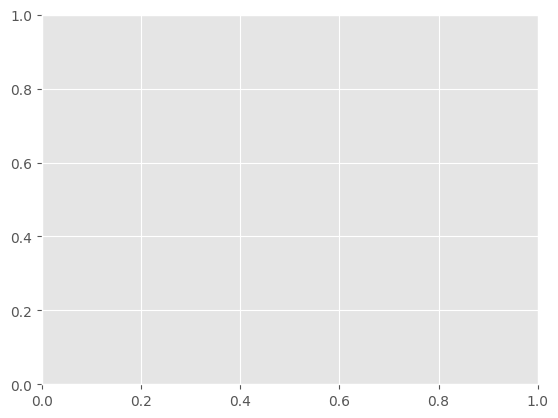

In [8]:
config = EcgConfig()
trainer = ECGClassifierTrainer(config)

train_confusion_matrix, eval_confusion_matrix, epoch_loss = trainer.train()

## Evaluating

In [10]:
# plot loss
plt.figure(1, dpi=200)
plt.plot(epoch_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
%matplotlib inline
plt.show()

NameError: name 'epoch_loss' is not defined

<Figure size 1280x960 with 0 Axes>

In [ ]:
# Confusion matrix
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.imshow(train_confusion_matrix[0])
plt.title("Training Confusion Matrix")


plt.subplot(1, 2, 2)
plt.imshow(eval_confusion_matrix[-1])
plt.title("Validation Confusion Matrix")

plt.tight_layout()
plt.show()


## Save model and load model

In [ ]:
import torch
torch.save(model, "..\\model_save\\model.pth")
model_test = torch.load("..\\model_save\\model.pth")
print(model_test)

In [ ]:
import torch.quantization
model(torch.randn(1, config.model.signal_length, 1)).shape

# 使用 Eager Mode Quantization
# 將 torch.nn.Linear 的參數映射到 -127~127 之間
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)
torch.save(quantized_model, "..\\model_save\\model_quantized.pth")
model_test = torch.load("..\\model_save\\model_quantized.pth")

print(model_test)


In [ ]:
import einops
loader = get_data_loaders(DatasetConfig())
accuracy = 0
for signal, label in loader[Mode.eval]:
    p = model_test(einops.rearrange(signal, "b c e -> b e c"))
    print(p)
    print(label)
    # print(signal.shape, label.shape)
    print(p.argmax(1) == label)
    accuracy += torch.sum(p.argmax(1) == label)
    print(f"accuracy: {accuracy / config.dataset.batch_size}")
    break



## Parameter 提取

In [ ]:
for name in model_test.state_dict():
   print(name)

print(quantized_model.state_dict()['encoder.0.0.block.1.queries_projection._packed_params._packed_params'])